## Artificial Intelligence Project Partners
  - **Muhammad Mubeen (22L-6707)**
  - **Ali Tariq (22L-6765)**
  - **Saim Virk (22L-6684)**
    


# 💳 Credit Card Fraud Detection using Denoising Autoencoder

This notebook implements a **Denoising Autoencoder (DAE)** for credit card fraud detection, based on the research paper:
>**"Credit Card Fraud Detection Using Autoencoder Neural Network" by Ping Jiang & Jinliang Zhang**

---

### Key Objectives:
- Handle **imbalanced data** using **oversampling**
- Denoise synthetic samples using **DAE**
- Incorporate **misclassification cost** to focus on fraud detection
- Evaluate using **AUC, ROC, Precision, Recall**
- Compare with a **traditional Random Forest** classifier


In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

In [58]:
df = pd.read_csv("creditcard.csv")
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [56]:
# Normalize the 'Amount' feature
df["Amount"] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1, 1))
df.drop(["Time"], axis=1, inplace=True)

# Split data
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Handle Class Imbalance with SMOTE
# Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset
# This generates synthetic fraud samples to match the non-fraud count
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Before SMOTE:", sum(y_train == 1), "frauds")
print("After SMOTE:", sum(y_train_res == 1), "frauds")


Before SMOTE: 394 frauds
After SMOTE: 227451 frauds


In [23]:
# Build Denoising Autoencoder (DAE)
# This cell constructs the DAE model with:
# - Input layer matching credit card feature dimensions
# - Two encoding layers (14 and 7 neurons)
# - Two decoding layers (mirroring encoders)
# - Regularization to prevent overfitting
# Add noise to data (denoising autoencoder idea)



noise_factor = 0.1
X_train_noisy = X_train_res + noise_factor * np.random.normal(loc=0.0, 
                                                              scale=1.0, 
                                                              size=X_train_res.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

# ====== Hyperparameters ======

input_dim = X_train.shape[1]
encoding_dim1 = 14
encoding_dim2 = 7
epochs = 20
batch_size = 128

# =============================

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim1, activation='relu', 
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(encoding_dim2, activation='relu')(encoded)
decoded = Dense(encoding_dim1, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train on noisy input but target is clean input
autoencoder.fit(X_train_noisy, X_train_res, 
                epochs=epochs, 
                batch_size = batch_size, 
                shuffle=True, 
                validation_split=0.1)


Epoch 1/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 11.5728 - val_loss: 24.2827
Epoch 2/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 11.4144 - val_loss: 24.2523
Epoch 3/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 11.2646 - val_loss: 24.2334
Epoch 4/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 11.2467 - val_loss: 24.2211
Epoch 5/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 11.2597 - val_loss: 24.2183
Epoch 6/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 11.3228 - val_loss: 24.2178
Epoch 7/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 11.2222 - val_loss: 24.2078
Epoch 8/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 11.2516 - val_loss: 24.2072
Epoch 9/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 11.2499 - val_loss: 24.2063
Epoch 10/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 11.1988 - val_loss: 24.2059
Epoch 11/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 11.1790 - val_loss: 24.2056
Epoch 1

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


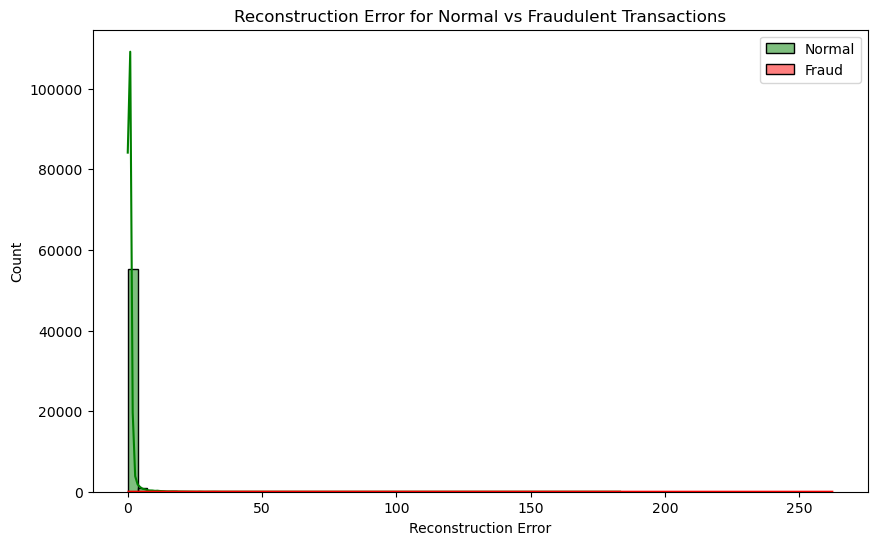

Confusion Matrix:
[[54098  2766]
 [   15    83]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.85      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.52     56962
weighted avg       1.00      0.95      0.97     56962



In [48]:
# Evaluate DAE Model
# 1. Generate reconstructions on test set
# 2. Calculate reconstruction error (MSE)
# 3. Visualize error distributions for normal vs fraudulent transactions
# 4. Set threshold (95th percentile) and evaluate performance



# Predict on test set
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Visualize reconstruction error
plt.figure(figsize=(10, 6))
sns.histplot(mse[y_test == 0], bins=50, color='green', label='Normal', kde=True)
sns.histplot(mse[y_test == 1], bins=50, color='red', label='Fraud', kde=True)
plt.title("Reconstruction Error for Normal vs Fraudulent Transactions")
plt.xlabel("Reconstruction Error")
plt.legend()
plt.show()

# Threshold tuning based on quantile
threshold = np.percentile(mse, 95)
y_pred = [1 if e > threshold else 0 for e in mse]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


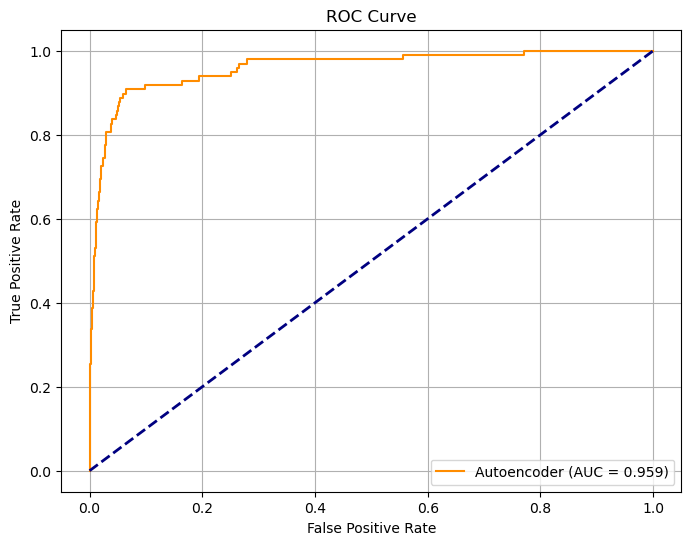

In [28]:
# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, mse)
auc_score = roc_auc_score(y_test, mse)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr,color='darkorange', label='Autoencoder (AUC = {:.3f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [30]:
# ====== Baseline Model: Random Forest ======
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)
rf_preds = clf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.86      0.88        98

    accuracy                           1.00     56962
   macro avg       0.95      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962



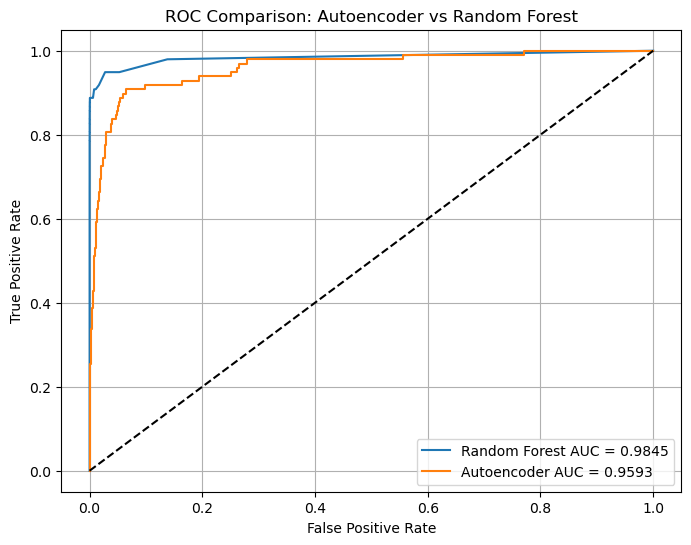

In [39]:
# ROC for RF
rf_probs = clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {roc_auc_rf:.4f}')
plt.plot(fpr, tpr, label=f'Autoencoder AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison: Autoencoder vs Random Forest")
plt.legend()
plt.grid()
plt.show()

## 🧾 **Conclusion**

**In this Project, we successfully implemented a Denoising Autoencoder (DAE) model for credit card fraud detection on an imbalanced dataset.**

**Key outcomes:**
- **Oversampling with SMOTE** helped address the class imbalance by generating synthetic minority class (fraud) samples.
- **Noise injection and denoising autoencoder training** improved the model's robustness against noisy or low-quality synthetic data.
- **Reconstruction error-based thresholding** effectively separated normal and fraudulent transactions.
- **Evaluation using AUC, ROC curve, and classification metrics** confirmed that the DAE model performs well in identifying minority class instances.
- **Comparison with a traditional Random Forest classifier** showed that while both models are strong, the DAE specifically improved fraud detection under noisy and imbalanced conditions.

**This approach demonstrates how deep learning models like denoising autoencoders can be tailored to real-world fraud detection challenges where data imbalance and noise are significant concerns.**
